In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt 
from tqdm.auto import tqdm
from copy import deepcopy

import gym

from stable_baselines3.ppo import PPO

from cppo import CPPO_Policy
from env import SlindingAntEnv

from utils import RewardLoggerCallback

In [2]:
settings = {
    'policy_kwargs': {'net_arch': [{'pi': [256, 256], 'vf':[256, 256]}], 
                      'activation_fn': nn.Tanh,
                      'optimizer_class': torch.optim.Adam,
                      'optimizer_kwargs': {
                          'betas': (0.9, 0.999)
                      }
                     },
    'n_steps': 4096,
    'n_epochs': 10,
    'batch_size': 128,
    'gae_lambda': 0.95,
    'gamma': 0.99,
    'clip_range': 0.2,
    'learning_rate': 1e-4,
    'tensorboard_log': './ant_tensorboard/'
}

cppo_rho_m_options = [
    (10**-3, int(1e2)),
    (10**-3, int(5e2)),
    (10**-4, int(5e3)),
    (10**-4, int(5e2)),
    (10**-5, int(1e4)),
    (10**-5, int(5e4))
]

cppo_option_index = 2

cppo_settings = deepcopy(settings)
cppo_settings['policy_kwargs']['optimizer_kwargs'] |= {
    'rho': cppo_rho_m_options[cppo_option_index][0],
    'm': cppo_rho_m_options[cppo_option_index][1]
}

total_timesteps = 1_000_000 # 100_000_000

In [3]:
env = SlindingAntEnv(total_timesteps//10)

In [4]:
ppo = PPO("MlpPolicy", env, **settings)

In [5]:
ppo.learn(total_timesteps=total_timesteps, progress_bar=True, callback=RewardLoggerCallback(), tb_log_name='baseline')

Output()

In [7]:
env = SlindingAntEnv(total_timesteps//10)

In [8]:
cppo = PPO(CPPO_Policy, env, **cppo_settings)

In [9]:
cppo.learn(total_timesteps=total_timesteps, progress_bar=True, callback=RewardLoggerCallback(), tb_log_name=f'cppo {cppo_option_index}') # TODO Add hyper parameter logging calback

Output()

In [20]:
ages = np.concatenate([v['age'].cpu().detach() for v in cppo.policy.optimizer.cbp_vals.values()])
print('Ages:', ages.mean(), '±', ages.std(), ', min:', ages.min(), ', max:', ages.max())

Ages: 19190.328125 ± 26128.961208694443 , min: 5 , max: 78400


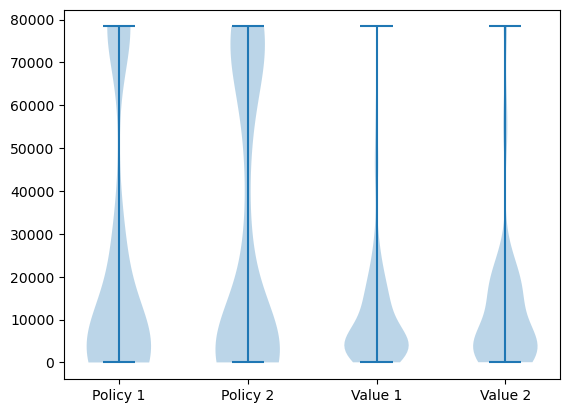

In [23]:
plt.violinplot([cppo.policy.optimizer.cbp_vals[l]['age'].cpu().detach() for l in cppo.policy.optimizer.linear_layers[0] + cppo.policy.optimizer.linear_layers[1]])
plt.xticks([1, 2, 3, 4], ['Policy 1', 'Policy 2', 'Value 1', 'Value 2'])
plt.show()

In [ ]:
# TODO
# add hyperparameter logging
# add logging for avereage/max feature age
# add joblib or similar